In [2]:
from constants import *
from functions import *
import numpy as np
from scipy.integrate import solve_ivp
import math
from units import *
from scipy.optimize import root_scalar
from numba import njit
from scipy.interpolate import interp1d
from scipy.interpolate import RegularGridInterpolator

In [3]:
plt.rcParams['font.size']=22
plt.rcParams['axes.linewidth']=2
plt.rcParams['xtick.major.size']=10
plt.rcParams['xtick.minor.size']=5
plt.rcParams['xtick.major.width']=2
plt.rcParams['xtick.minor.width']=1
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.major.size']=10
plt.rcParams['ytick.minor.size']=5
plt.rcParams['ytick.major.width']=2
plt.rcParams['ytick.minor.width']=1
plt.rcParams['ytick.direction']='in'

In [4]:
filename = "CloudyData_UVB=HM2012.h5"
Z = 0.3
with h5py.File(filename, "r") as f:
    cloudy_table = f["CoolingRates/Metals/Cooling"][:,0,:]
    mmw = f["CoolingRates/Primordial/MMW"][:,0,:]

cloudy_table *= Z
log10nH_arr = np.linspace(-10.,4, cloudy_table.shape[0])
log10temp_arr = np.linspace(1.,9, cloudy_table.shape[1])

log10lambda_cloudy = interpolate.RegularGridInterpolator(
    (log10nH_arr, log10temp_arr),
    np.log10(cloudy_table),
    bounds_error=False,
    fill_value=None
)

mmw_cloudy = interpolate.RegularGridInterpolator(
    (log10nH_arr, log10temp_arr),
    mmw,
    bounds_error=False,
    fill_value=None
)


In [5]:

rho_arr = 10.**log10nH_arr
temp_arr =10**log10temp_arr
lnT   = np.log(temp_arr)
lnrho = np.log(rho_arr)
lnLambda = np.log(cloudy_table)

dlnLambda_dlnrho, dlnLambda_dlnT = np.gradient(
    lnLambda,
    lnrho,
    lnT,
    edge_order=2
)

interp_dlnLambda_dlnrho = RegularGridInterpolator(
    (lnrho, lnT),
    dlnLambda_dlnrho,
    bounds_error=False,
    fill_value=None
)

interp_dlnLambda_dlnT = RegularGridInterpolator(
    (lnrho, lnT),
    dlnLambda_dlnT,
    bounds_error=False,
    fill_value=None
)

In [6]:
X = 0.75
mu = 0.61
# Mhalo = 1.e10* Msun
# Mdot  = 0.1 * Msun/yr_to_sec/25.

Mhalo = 1.e12* Msun
Ms_Mh = 0.02

In [7]:
r_grid = np.logspace(np.log10(0.001*kpc), np.log10(25*Rvir(Mhalo)), 1000)
vc_grid = np.zeros(r_grid.shape[0])
i = 0
for r in r_grid:
    vc_grid[i] = v_c(r, Mhalo, Ms_Mh)       
    i+=1
vc_interp = interp1d(r_grid,vc_grid)

In [8]:
lnvc_grid = np.log(vc_grid)
lnr_grid  = np.log(r_grid)

dlnvc_dlnr_grid = np.gradient(lnvc_grid, lnr_grid)
dlnvc_dlnr_grid_interp =  interp1d(r_grid,dlnvc_dlnr_grid)


In [9]:
def soln_at_esp(v_rsonic, T_rsonic, rho_rsonic, rsonic, eps):
    
    dlnvc_dlnr_at_Rsonic = dlnvc_dlnr_grid_interp(rsonic)
    
    vc_rsonic  = vc_interp(rsonic)
    
    cs_rsonic  = v_rsonic
    x = (vc_rsonic/cs_rsonic)**2/2.
    a = 1.0
    
    lnrho = np.log(rho_rsonic)
    lnT = np.log(T_rsonic)
                 
    constant1 = interp_dlnLambda_dlnT((lnrho, lnT)) + 1.5 *  interp_dlnLambda_dlnrho((lnrho, lnT))

    b = 29.0* x/6 - 17.0/6.0 + ((1.-x)/3.) * constant1
    
    constant2 = interp_dlnLambda_dlnrho((lnrho, lnT))

    c = ((2./3.) * x * dlnvc_dlnr_at_Rsonic) +  (5*x*x) - (13.*x/3.0) + (2./3.)  - (5.*(1-x)**2/3.)*constant2
    
    sol1 = (-b - np.sqrt(b*b - 4*a*c))/(2.*a*c)
    sol2 = (-b + np.sqrt(b*b - 4*a*c))/(2.*a*c)
    sol = np.asarray([sol1,sol2])
    dlnv_dlnr_at_Rsonic = -1.5* sol + 3 - 5*x
    dlnM_dlnr = dlnv_dlnr_at_Rsonic - 0.5 * sol
    if(dlnM_dlnr[0]<0.0):   
        dlnT_dlnr_at_Rsonic = sol1
    elif(dlnM_dlnr[1]<0.0):
        dlnT_dlnr_at_Rsonic = sol2
    
    dlnv_dlnr_at_Rsonic = -1.5* dlnT_dlnr_at_Rsonic + 3 - 5*x
    
    delT = 1. + dlnT_dlnr_at_Rsonic * eps
    delv = 1. + dlnv_dlnr_at_Rsonic * eps
    delrho = 1. - (dlnv_dlnr_at_Rsonic + 2.) * eps
    
    T_ini = delT * T_rsonic
    v_ini = delv * v_rsonic
    rho_ini = delrho * rho_rsonic
    r_ini = (1.0 + eps) * rsonic

    return r_ini, v_ini, T_ini, rho_ini
    

In [16]:
 def find_init_at_Rsonic_varying_lambda(rsonic, T):

    # Sonic velocity
    cs = np.sqrt(gamma * kb * T / mu / mp)
    v  = cs
    vc = vc_interp(rsonic)

    # Flow time
    tflow = rsonic / v

    # ---- Build a grid in nH ----
    nHs = 10.0**np.arange(-7, 10, 0.01) 

    # Pressures
    Ps = (nHs * kb * T) / (X * mu)

    log10nH = np.log10(nHs)
    log10T = np.log10(T)
    lambda_cool = 10.**(log10lambda_cloudy((log10nH, log10T))) 
    tcools = Ps/(gamma-1)/ (nHs**2 * lambda_cool)

    # Compute f(nH):
    # f = 2 - (vc/v)^2 - tflow/(gamma*tcool)
    fvals_np = 2.0  - (vc/v)**2 - (tflow / (gamma * tcools))

    sign_changes = np.where(
        np.sign(fvals_np[:-1]) * np.sign(fvals_np[1:]) < 0)[0]

    if len(sign_changes) != 1:
        raise RuntimeError(
            f"Could not find unique root for nH; number of sign changes = {len(sign_changes)}"
        )

    i = sign_changes[0]

    # ---- Interpolate to find nH where f = 0 ----
    nH_low  = nHs[i]
    nH_high = nHs[i+1]
    f_low   = fvals_np[i]
    f_high  = fvals_np[i+1]
    
    # linear interpolation in log space for stability
    lnH = np.interp(
        0.0,
        [f_low, f_high],
        [np.log10(nH_low), np.log10(nH_high)]
    )

    best_nH = (10.0**lnH)

    # ---- Compute rho and Mdot ----
    rho = best_nH * mp / X

    Mdot = 4.0 * np.pi * rho * rsonic**2 * v

    return v, rho, Mdot


In [40]:

def flow_equations_lnr(lnr, ini_val, Mdot):
    
    logT, logrho = ini_val
    T = np.exp(logT)
    rho = np.exp(logrho)
    r   = np.exp(lnr)
    
    v = Mdot/(4.*math.pi*r*r*rho)
    
    nH = X * rho/mp
    cs = np.sqrt(gamma * kb * T/(mu * mp))
    # print('CS=',cs/kmps, v/kmps)
    P  = cs*cs*rho/gamma
    
    lambda_cool = 10.**(log10lambda_cloudy((np.log10(nH), np.log10(T)))) 
    # lambda_cool = 0.6e-22
    
    tcool = P/((gamma-1) * nH * nH *  lambda_cool)
    
    
    Mach = np.abs(v)/cs
    tflow = r/np.abs(v)
    tratio = tflow/tcool
    vc_over_cs = vc_interp(r)/cs

    dlnrho_dlnr =  (-tratio/gamma - vc_over_cs + 2*Mach**2)  / (1-Mach**2)
    dlnT_dlnr = tratio + dlnrho_dlnr*(gamma-1)
    
    return dlnT_dlnr, dlnrho_dlnr

In [41]:
def find_sol(v_rsonic, T_rsonic, rho_rsonic, Mdot, rsonic):
    
    eps = 1.e-5

    rmin  =  rsonic*(1.+eps)
    rmax  =  20.* Rvir(Mhalo)
    
    r_ini, v_ini, T_ini, rho_ini = soln_at_esp(v_rsonic, T_rsonic, rho_rsonic, rsonic, eps)
   
    ini_value = [T_ini, rho_ini]
    
    log_ini_value = np.log(ini_value)
    lnr_span = (np.log(r_ini), np.log(rmax))
    lnr_eval = np.linspace(lnr_span[0], lnr_span[1], 2000)
    
    sol = solve_ivp(flow_equations_lnr, lnr_span, log_ini_value, t_eval=lnr_eval, method='RK45',args=(Mdot,))
    
    lnT_sol, lnrho_sol = sol.y
    return lnT_sol, lnrho_sol, lnr_eval, Mdot

In [19]:
#Constant lambda=0.6e-22
# rsonic = 0.6 * kpc
# vc = vc_interp(rsonic)
# T_rsonic =  *  mu * mp * vc**2/gamma/kb
# T_rsonic = 0.778015*  mu * mp * vc**2/gamma/kb
# T_rsonic = 0.7782*  mu * mp * vc**2/gamma/kb

#Grackle Cooling Table
rsonic = 1.*kpc
vc = vc_interp(rsonic)
T_rsonic  = 0.75*  mu * mp * vc**2/gamma/kb
# T_rsonic  = 0.77*  mu * mp * vc**2/gamma/kb

v_rsonic, rho_rsonic, Mdot = find_init_at_Rsonic_varying_lambda(rsonic,T_rsonic)
print(v_rsonic/kmps, rho_rsonic/mp, Mdot*yr_to_sec/Msun, T_rsonic/1.e6)
solution = find_sol(v_rsonic, T_rsonic, rho_rsonic, Mdot, rsonic)

133.7575531457651 0.05431737037386674 2.306330647808359 0.7936635130120918


/var/folders/bh/gk6r7v913g3dxj455c079xyh0000gq/T/ipykernel_19148/3688382635.py:5: RuntimeWarning: overflow encountered in exp
  rho = np.exp(logrho)
/var/folders/bh/gk6r7v913g3dxj455c079xyh0000gq/T/ipykernel_19148/3688382635.py:13: RuntimeWarning: invalid value encountered in scalar multiply
  P  = cs*cs*rho/gamma
/var/folders/bh/gk6r7v913g3dxj455c079xyh0000gq/T/ipykernel_19148/3688382635.py:15: RuntimeWarning: divide by zero encountered in log10
  lambda_cool = 10.**(log10lambda_cloudy((np.log10(nH), np.log10(T))))
/var/folders/bh/gk6r7v913g3dxj455c079xyh0000gq/T/ipykernel_19148/3688382635.py:21: RuntimeWarning: invalid value encountered in scalar divide
  Mach = np.abs(v)/cs
/var/folders/bh/gk6r7v913g3dxj455c079xyh0000gq/T/ipykernel_19148/3688382635.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  tflow = r/np.abs(v)
/var/folders/bh/gk6r7v913g3dxj455c079xyh0000gq/T/ipykernel_19148/3688382635.py:24: RuntimeWarning: divide by zero encountered in divide
  vc_over_cs 

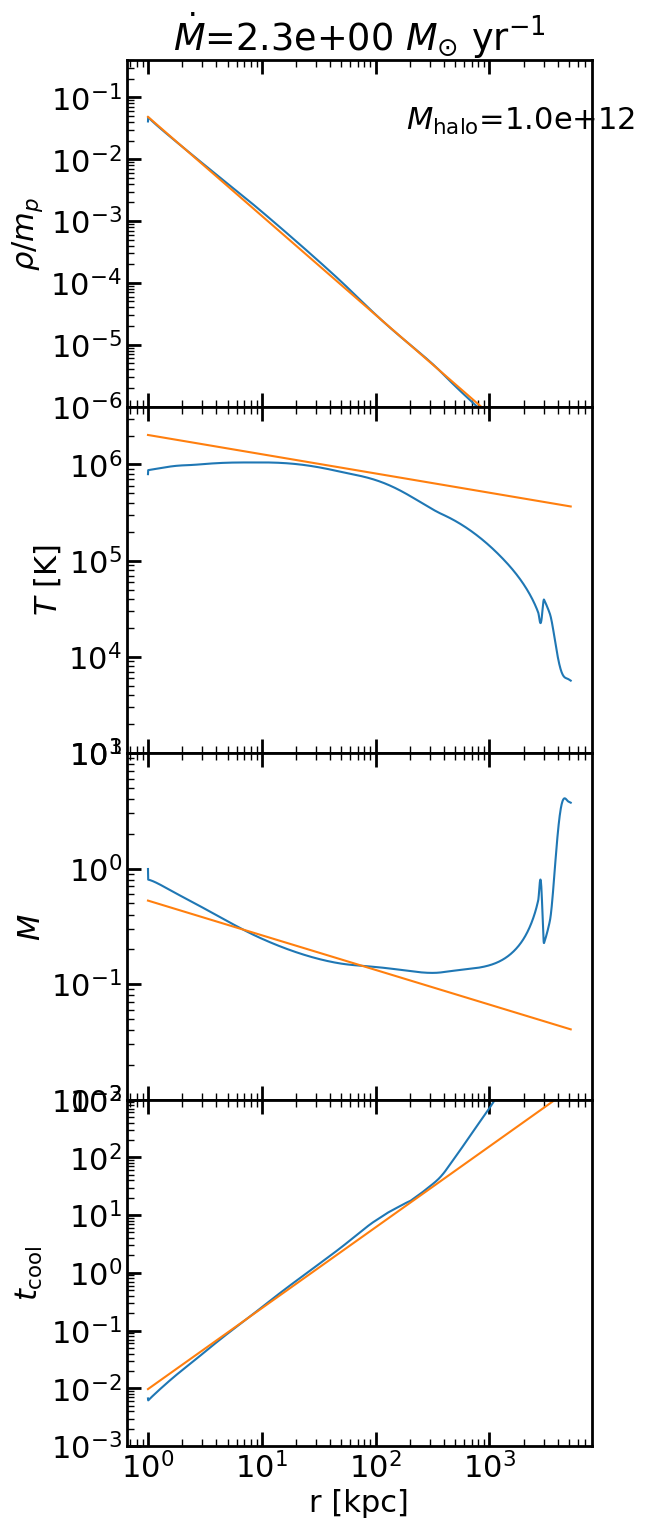

In [20]:
T = np.exp(solution[0])
rho = np.exp(solution[1])
lnr = (solution[2])
Mdot = solution[3]
cs = np.sqrt(gamma * kb * T/(0.6 * mp))
rkpc = np.exp(lnr)/kpc
r = rkpc*kpc
v = Mdot/(4*math.pi*r*r*rho)
Mach = v/cs
tflow = np.exp(lnr)/v
tff = np.sqrt(2) * r/v

tcool = np.zeros(rkpc.shape[0])
for i in range(tcool.shape[0]):
    P = kb * rho[i] * T[i]/0.6/mp
    nH = X * rho[i]/mp
    log10nH = np.log10(nH)
    log10T  = np.log10(T[i])
    cloudy  = 10.**(log10lambda_cloudy((log10nH, log10T))) 
    # cloudy = 0.6e-22
    tcool[i] = P/(nH*nH*cloudy*(gamma-1))

tratio = tcool/tflow

m=-0.1
vc = 140. * (rkpc/(100)) **m * kmps
A = 0.9 * (1.-2*m)
B = 1. + 4*m/3.
Tvir = T_vir(Mhalo)
Rvir_ = Rvir(Mhalo)
lambda_cool = 0.6e-22
Tranl = (6./(5.*A)) * Tvir * (r/Rvir_)**(2.*m)
Mach_anl  = X*A/mp/vc**2 * np.sqrt(5*Mdot *lambda_cool/(18.*math.pi*B*r))
nH_anl = vc * np.sqrt(9*B*Mdot/(40.*math.pi*A*r**3*lambda_cool))
tcool_anl = 7.2 * (Mhalo/(1.e12*Msun))**(0.36) * (Mdot/(Msun/yr_to_sec))**(-0.5) * (lambda_cool/1.e-22)**(-0.5) * (r/100/kpc)**(1.4) 
Rsonic = 0.06 * (Mhalo/(1.e12*Msun))**(-2.4) * (Mdot/(Msun/yr_to_sec))**(1.67) * (lambda_cool/1.e-22)**(0.36) * kpc
Rhalf = 3.0*(Mhalo/1e12/Msun)**(1/3)*kpc

fig, ax = plt.subplots(4, 1, gridspec_kw = {'wspace':0.1, 'hspace':0.0},figsize=(6, 18))

ylabel = [r'$\rho/m_p$', r'$T$ [K]', r'$M$', r'$t_{\rm cool}$']

ax[0].plot(rkpc, rho*X/mp)
ax[0].plot(rkpc, nH_anl)
ax[1].plot(rkpc, T)
ax[1].plot(rkpc, Tranl)
ax[2].plot(rkpc, Mach)
ax[2].plot(rkpc, Mach_anl)
ax[3].plot(rkpc, tcool/yr_to_sec/1.e9)
ax[3].plot(rkpc, tcool_anl)


ax[-1].set_xlabel('r [kpc]')
for i in range(4):
    ax[i].set_ylabel(ylabel[i])
plt.setp(ax, 'xscale', ('log'))
plt.setp(ax, 'yscale', ('log'))
# plt.setp(ax, 'xlim', (0.5,2.e3))
ax[0].set_ylim(1.e-6, 4.e-1)
ax[1].set_ylim(1.e3, 4.e6)
ax[2].set_ylim(1.e-2,1.e1)
ax[3].set_ylim(1.e-3,1.e3)

ax[0].tick_params(axis='x', which='both', labelbottom=False, top=True, bottom=True)
ax[1].tick_params(axis='x', which='both', labelbottom=False, top=True, bottom=True)
ax[-2].tick_params(axis='x', which='both', top=True, bottom=True, labelbottom=False)
ax[-1].tick_params(axis='x', which='both', top=True, bottom=True, labelbottom=True)
ax[0].set_title(r'$\dot{M}$=%.1e'%(Mdot*yr_to_sec/Msun) + r' $M_{\odot} \ \rm{yr}^{-1}$')
ax[0].text(0.6, 0.8, r'$M_{\rm halo}$=%.1e'%(Mhalo/Msun), transform=ax[0].transAxes)
# ax[0].text(0.6, 0.7, r'$M_{\rm gas}$=%.1e'%(tot_gas_mass/Msun), transform=ax[0].transAxes)
# ax[0].text(0.6, 0.7, r'$\rho_{\rm ini}$=%.1e'%(rho0/mp), transform=ax[0].transAxes)
# ax[0].text(0.6, 0.6, r'$T_{\rm ini}$=%.1e'%(T), transform=ax[0].transAxes)

image_name = 'Figures/solution_' + str(Mdot*yr_to_sec/Msun) +'.jpeg'
# plt.savefig(image_name, bbox_inches='tight')

np.float64(-0.1143316938323048)

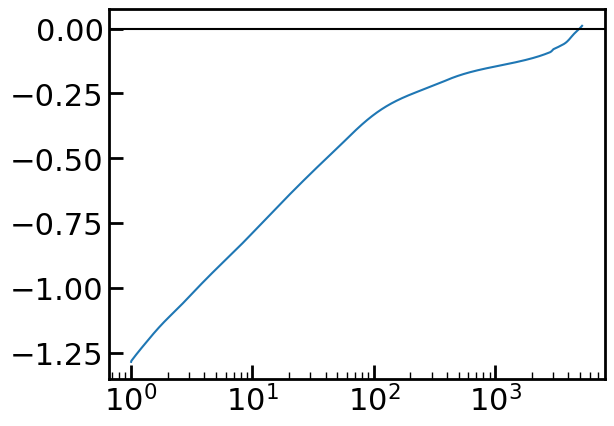

In [21]:
T = np.exp(solution[0])
rho = np.exp(solution[1])
lnr = (solution[2])
Mdot = solution[3]

cs = np.sqrt(gamma * kb * T/(mu * mp))

cs_mid = 0.5*(cs[:-1] + cs[1:])
rho_mid = 0.5 * (rho[:-1] + rho[1:])

r_grid = np.exp(lnr)
r_mid = 0.5 * (r_grid[:-1] + r_grid[1:])
dr_grid = np.diff(r_grid)

v_mid = Mdot/(4*math.pi*r_mid**2*rho_mid)

dphi = vc_interp(r_mid) **2 * dr_grid/r_mid
phi_int = -np.cumsum(dphi)
phi = -phi_int + phi_int[-1]
Bern_param = v_mid*v_mid/2.0 + cs_mid*cs_mid/(gamma-1) + phi

Rcool = 130 * (Mhalo/(1.e12*Msun))**(-0.26) * (lambda_cool/1.e-22)**(0.36) * kpc
Rmax = 2000. * kpc
idx = np.argmin(np.abs(r - Rmax))
plt.plot(r_mid/kpc, (Bern_param/1.e5/kmps/kmps))
plt.axhline(0.0, color='black')
# plt.xlim(1.e-1, 1.e3)

plt.xscale('log')
Bern_param[idx]/1.e5/kmps/kmps

In [22]:
def solve_for_B(T_rsonic, rsonic):

    v_rsonic, rho_rsonic, Mdot = find_init_at_Rsonic_varying_lambda(rsonic, T_rsonic)
    
    solution = find_sol(v_rsonic, T_rsonic, rho_rsonic, Mdot, rsonic)
    
    lnT = solution[0]
    lnrho = solution[1]
    lnr  = solution[2]
    Mdot = solution[3]

    r = np.exp(lnr)
    T = np.exp(lnT)
    rho = np.exp(lnrho)
    v = Mdot/(4.*math.pi*r*r*rho)
    
    cs = np.sqrt(gamma * kb * T/(mu * mp))
    cs_mid = 0.5*(cs[:-1] + cs[1:])
    v_mid  = 0.5 * (v[:-1] + v[1:])
    rho_mid = 0.5 * (rho[:-1] + rho[1:])
    T_mid = 0.5 * (T[:-1] + T[1:])
    r_grid = np.exp(lnr)
    
    r_mid = 0.5 * (r_grid[:-1] + r_grid[1:])
    dr_grid = np.diff(r_grid)
    dphi = vc_interp(r_mid) **2 * dr_grid/r_mid
    phi_int = -np.cumsum(dphi)

    phi = -phi_int + phi_int[-1]
    Bern_param = v_mid*v_mid/2.0 + cs_mid*cs_mid/(gamma-1) + phi
    return Bern_param, r_mid, v_mid, cs_mid, rho_mid, T_mid
    

In [23]:
_last_solution = {}

def B_final_from_T(T_rsonic, rsonic):
    global _last_solution
    try:
        Bern, r_mid, v_mid, cs_mid, rho_mid, T_mid = solve_for_B(T_rsonic, rsonic)
        Rcool = 130 * (Mhalo/(1.e12*Msun))**(-0.26) * (lambda_cool/1.e-22)**(0.36) * kpc
        Rmax = 2000. * kpc
        idx = np.argmin(np.abs(r_mid - Rmax))
        _last_solution = {
            "r_mid": r_mid,
            "v_mid": v_mid,
            "cs_mid": cs_mid,
            "rho_mid": rho_mid,
            "Bern": Bern,
            "T_mid": T_mid
        }
        # If integration failed or produced NaNs, treat as unbound → positive
        if np.any(np.isnan(Bern)):
            return 1e10
        return (Bern[idx])  # Bernoulli at Rcool

    except Exception:
        return 1e10

def find_T_sonic(rsonic, Mhalo,  Tlow, Thigh):
    vc = vc_interp(rsonic)
    T_low = Tlow
    T_high = Thigh
    sol = root_scalar(
        B_final_from_T,
        args=(rsonic,),
        bracket=[T_low, T_high],
        method='bisect',
        xtol=1e-8
    )
    
    final_solution = _last_solution
    return sol.root, final_solution


In [24]:
#Grackle Cooling Rate
rsonic = 1. * kpc
vc = vc_interp(rsonic)
T_low  = 0.75*  mu * mp * vc**2/gamma/kb
T_high = 0.77 *  mu * mp * vc**2/gamma/kb

root, solution = find_T_sonic(rsonic, Mhalo, T_low, T_high)

/var/folders/bh/gk6r7v913g3dxj455c079xyh0000gq/T/ipykernel_19148/3688382635.py:5: RuntimeWarning: overflow encountered in exp
  rho = np.exp(logrho)
/var/folders/bh/gk6r7v913g3dxj455c079xyh0000gq/T/ipykernel_19148/3688382635.py:13: RuntimeWarning: invalid value encountered in scalar multiply
  P  = cs*cs*rho/gamma
/var/folders/bh/gk6r7v913g3dxj455c079xyh0000gq/T/ipykernel_19148/3688382635.py:15: RuntimeWarning: divide by zero encountered in log10
  lambda_cool = 10.**(log10lambda_cloudy((np.log10(nH), np.log10(T))))
/var/folders/bh/gk6r7v913g3dxj455c079xyh0000gq/T/ipykernel_19148/3688382635.py:21: RuntimeWarning: invalid value encountered in scalar divide
  Mach = np.abs(v)/cs
/var/folders/bh/gk6r7v913g3dxj455c079xyh0000gq/T/ipykernel_19148/3688382635.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  tflow = r/np.abs(v)
/var/folders/bh/gk6r7v913g3dxj455c079xyh0000gq/T/ipykernel_19148/3688382635.py:24: RuntimeWarning: divide by zero encountered in divide
  vc_over_cs 

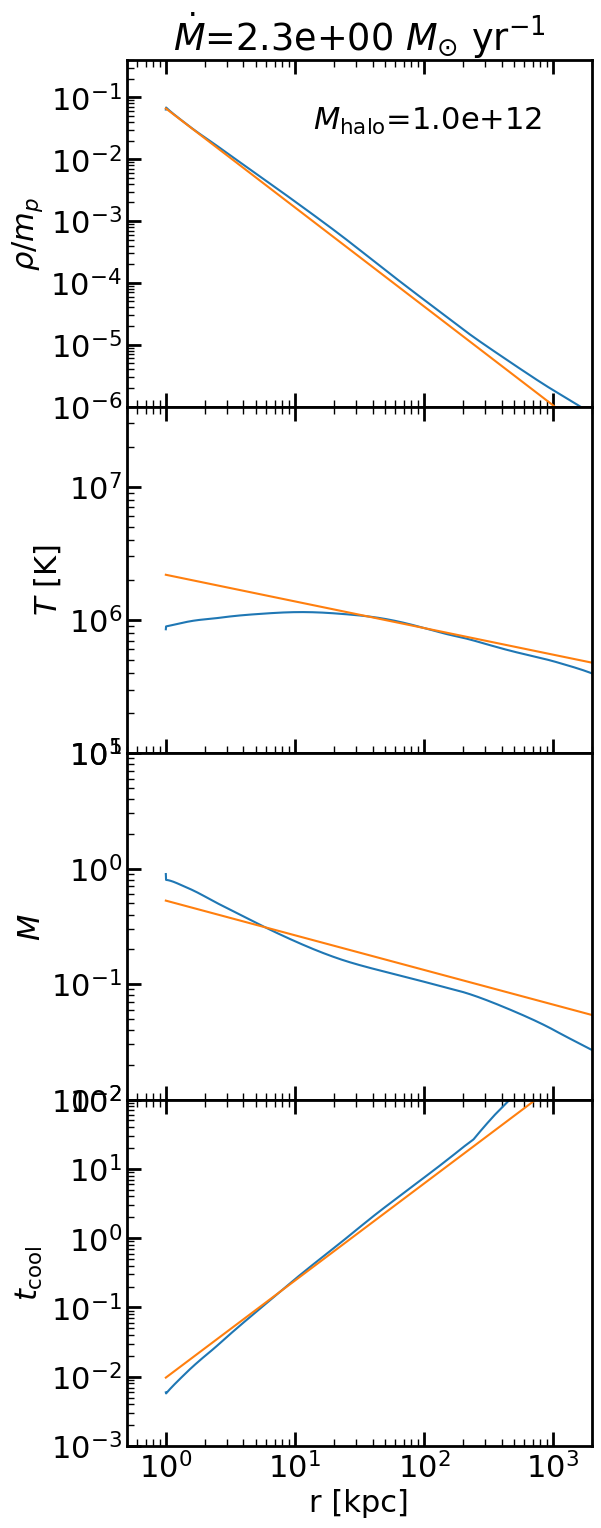

In [25]:
r = solution["r_mid"]
v = solution["v_mid"]
cs = solution["cs_mid"]
rho = solution["rho_mid"]
T = solution["T_mid"]

Mach = v/cs
rkpc = r/kpc
tflow = r/v
tff = np.sqrt(2) * r/v

tcool = np.zeros(rkpc.shape[0])
for i in range(tcool.shape[0]):
    P = kb * rho[i] * T[i]/mu/mp
    nH = X*rho[i]/mp
    log10nH = np.log10(nH)
    log10T  = np.log10(T[i])
    cloudy  = 10.**(log10lambda_cloudy((log10nH, log10T)))
    tcool[i] = P/(nH*nH*cloudy*(gamma-1))

tratio = tcool/tflow

m=-0.1
vc = 140. * (rkpc/(100)) **m * kmps
A = 0.9 * (1.-2*m)
B = 1. + 4.*m/3.
Tvir = T_vir(Mhalo)
Rvir_ = Rvir(Mhalo)
Tranl = mu * mp * vc*vc/gamma/kb

Mach_anl  = X*A/mp/vc**2 * np.sqrt(5*Mdot *lambda_cool/(18.*math.pi*B*r))
nH_anl    = 1.6e-5 * (Mhalo/(1.e12*Msun))**(0.36) * (Mdot/(Msun/yr_to_sec))**0.5 * (lambda_cool/1.e-22)**(-0.5) * (r/100/kpc)**(-1.6)
tcool_anl = 7.2 * (Mhalo/(1.e12*Msun))**(0.36) * (Mdot/(Msun/yr_to_sec))**(-0.5) * (lambda_cool/1.e-22)**(-0.5) * (r/100/kpc)**(1.4)


fig, ax = plt.subplots(4, 1, gridspec_kw = {'wspace':0.1, 'hspace':0.0},figsize=(6, 18)) 

ylabel = [r'$\rho/m_p$', r'$T$ [K]', r'$M$', r'$t_{\rm cool}$']

ax[0].plot(rkpc, rho/mp)
ax[0].plot(rkpc, nH_anl/X)
ax[1].plot(rkpc, T)
ax[1].plot(rkpc, Tranl)
ax[2].plot(rkpc, Mach)
ax[2].plot(rkpc, Mach_anl)
ax[3].plot(rkpc, tcool/yr_to_sec/1.e9)
ax[3].plot(rkpc, tcool_anl)
# ax[3].plot(rkpc, tratio)


ax[-1].set_xlabel('r [kpc]')

for i in range(4):
    ax[i].set_ylabel(ylabel[i])
plt.setp(ax, 'xscale', ('log'))
plt.setp(ax, 'yscale', ('log'))
plt.setp(ax, 'xlim', (0.5,2.e3))
ax[0].set_ylim(1.e-6, 4.e-1)
ax[1].set_ylim(1.e5, 4.e7)
ax[2].set_ylim(1.e-2,1.e1)
ax[3].set_ylim(1.e-3,1.e2)

ax[0].tick_params(axis='x', which='both', labelbottom=False, top=True, bottom=True)
ax[1].tick_params(axis='x', which='both', labelbottom=False, top=True, bottom=True)
ax[-1].tick_params(axis='x', which='both', top=True, bottom=True, labelbottom=True)
ax[0].set_title(r'$\dot{M}$=%.1e'%(Mdot*yr_to_sec/Msun) + r' $M_{\odot} \ \rm{yr}^{-1}$')
ax[0].text(0.4, 0.8, r'$M_{\rm halo}$=%.1e'%(Mhalo/Msun), transform=ax[0].transAxes)
# ax[0].text(0.6, 0.7, r'$M_{\rm gas}$=%.1e'%(tot_gas_mass/Msun), transform=ax[0].transAxes)
# ax[0].text(0.6, 0.7, r'$\rho_{\rm ini}$=%.1e'%(rho0/mp), transform=ax[0].transAxes)
# ax[0].text(0.6, 0.6, r'$T_{\rm ini}$=%.1e'%(T), transform=ax[0].transAxes)

image_name = 'Figures/solution_' + str(Mdot*yr_to_sec/Msun) +'.jpeg'
# plt.savefig(image_name, bbox_inches='tight')